In [1]:
using LinearAlgebra
using Plots
using SparseArrays





using Distributions
using JLD

using Flux
using Random
using LaTeXStrings
using ProgressBars
using Zygote
stop_gradient(f) = f()
Zygote.@nograd stop_gradient

In [2]:
struct ROM_struct
    basis
    local_basis
    S
    S_inv
    f
    P
    A
    p_A
end

function gen_ROM(snapshots,f;r=1,I=10,overlap = 1,localize = true)
    N = size(snapshots)[1]
    J = Int(N/I)
    if localize

        m = reshape( snapshots,(J,I,size(snapshots)[2]))
        snapshots = m
        for i in 1:overlap
            snapshots = [snapshots;circshift(m,(0,-i,0))]
        end

        snapshots = reshape(snapshots,(size(snapshots)[1],size(snapshots)[2]*size(snapshots)[3]))
        if overlap == 0
            local_basis = svd(snapshots).U[:,1:r]
        else
            #local_basis = svd(hat_funct(size(snapshots)[1],overlap = overlap) .* snapshots).U[:,1:r]
            local_basis = svd(hat_funct(size(snapshots)[1],overlap = overlap) .* snapshots).U[:,1:r]
        end


        offset = 0
        basis = zeros(N,(I)*r)
        total_modes = size(basis)[2]
        width = size(local_basis)[1]
        for i in 1:I
            basis[1:width,1:r] = local_basis
            basis = circshift(basis,(J,r))
        end
    else
        basis = svd(snapshots).U[:,1:I*r]
        local_basis = basis
        total_modes = size(basis)[2]

    end
    if localize
        basis = sparsify_matrix(basis)
    end
    S = basis' * basis
    S_inv = inv(Matrix(S))
    A = gen_operator(x,f,basis)
    _f_ = 0
    S_inv_A = S_inv*A
    if localize == false
        A = Matrix(A)
    end
    P = basis * S_inv * basis'
                    
    p_A = basis *S_inv * A * S_inv*basis' 

    function _f_(a,x,t,S=S,S_inv = S_inv,A = A,S_inv_A = S_inv_A,overlap = overlap,localize = localize)
        
        if overlap >= 1 && localize == true
            dadt = S_inv_A*a
        else
            dadt = A*a
        end
        return dadt
    end
    
    #_f_(a,x,t, S = S, A = A) =  (A*a)
    #_f_(a,x,t,S_inv = S_inv,basis = basis) = S_inv*(basis'*f(basis*a,x,t))
    return ROM_struct(basis,local_basis, S,S_inv,_f_,P,A,p_A)
end
    

function sparsify_matrix(A,tolerance = 1e-10)
    B = spzeros(size(A))
    for i in 1:size(A)[1]
        for j in 1:size(A)[2]
            if abs(A[i,j]) >= tolerance
                B[i,j] += A[i,j]
            end
        end 
    end
    return B
end

function hat_funct(n;overlap = 0)
    eval = collect(1:n) .- 1/2
    return sin.(pi/(n)*eval).^(2)
end

function simulation(u0,x,dt,T,f;F = 0,save_every= 1)
    
    f_plus_forcing(u,x,t) = f(u,x,t) .+ F

    t= 0.
    u = u0

    ############
    us = Array{Float64}(undef, size(u0)[1], 0)
    dus = Array{Float64}(undef,  size(u0)[1],0)
    ts = Array{Float64}(undef,  1,0)
    ############
    save_counter = save_every + 1
    counter = 1
    round_t = t
    while round_t <= T
        du = RK4(u,x,t,dt,f_plus_forcing)
        if save_counter > save_every
            #############################################

            us = cat((us, u)...,dims = 2)

            dus = cat((dus, f(u,x,t))...,dims = 2) #-forcing

            if length(size(u0)) > 1
                ts= [ts t*ones(1,size(u0)[2])]
            else
                ts = [ts t]
            end
            #############################################
            save_counter = 1
            counter += 1

        end
        u = u .+ dt*du

        t += dt
        save_counter += 1
        round_t = stop_gradient() do
            round(t,digits =10)
        end
    end
    return us,dus,ts
end
                                                        
function simulation(u0,x,dt,T,f;F = 0,save_every= 1)
    
    f_plus_forcing(u,x,t) = f(u,x,t) .+ F

    t= 0.
    u = u0
    
    save_counter = save_every + 1
    counter = 0
    round_t = t
    ############
    while round_t <= T
        if save_counter > save_every
            #############################################
            save_counter = 1
            counter += 1
        end
        t += dt
        save_counter += 1
        round_t = stop_gradient() do
            round(t,digits =10)
        end
    end                                                   
    t = 0.                                                       
                                                            
    us = zeros(size(u0)[1], counter)
    dus = zeros(size(u0)[1], counter)
    ts = zeros(1,counter)
    ############
    save_counter = save_every + 1
    counter = 0
    round_t = t
    while round_t <= T
        du = RK4(u,x,t,dt,f_plus_forcing)
        if save_counter > save_every
            #############################################
            counter += 1
            us[:,counter] += u

            dus[:,counter] += f(u,x,t) 

            ts[1,counter] += t
            #############################################
            save_counter = 1


        end
        u = u .+ dt*du

        t += dt
        save_counter += 1
        round_t = stop_gradient() do
            round(t,digits =10)
        end
    end
    return us,dus,ts
end                                                       
                                        

function gen_operator(x,f,basis)
    input = zeros(size(basis)[2])
    dims = size(basis)[2]
    
    lin_operator = spzeros(dims,dims)
    
    mat = inv([[1,2];;[1,4]])
    
    for i in 1:dims
        input = 0*input
        input[i] += 1
        output1 = (basis' * f(basis*input,x,0))
        input[i] += 1
        output2 = (basis' * f(basis*input,x,0))
        for h in 1:dims
            if output1[h] != 0
                a,b = mat * [output1[h],output2[h]]
                lin_operator[h,i] = a
                #@assert b == 0
            end
        end
    end

                
    return lin_operator
end

function index_converter(i,I)
    index = mod(i,I)
    if index == 0
        index = I
    end
    return index
end


function interpolation_matrix(x1,x2)
    h1 = x1[2] - x1[1]
    h2 = x2[2] - x2[1]
    M = spzeros(size(x1)[1],size(x2)[1])
    for i in 1:size(x1)[1]
        index = (x1[i]+x2[1])/h2
        fl = floor(Int,index)
        ce = ceil(Int,index)
        if fl-ce == 0
            weight = 1
        else
            weight = index - fl
        end
        M[i,index_converter(fl,size(x2)[1])] = 1-weight
        M[i,index_converter(ce,size(x2)[1])] = weight
    end
    return M
end
                                                                    
function compute_error(a;average = true)
    if average
        return mean(sqrt.(sum(a.^2,dims = 1)))
    else
        return sqrt.(sum(a.^2,dims = 1))
    end
end

compute_error (generic function with 1 method)

In [3]:
hoi = zeros(10,500)
compute_error(hoi,average = false)

1×500 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [4]:
function gen_stencil(N,coeffs,positions)
    mat = spzeros((N,N))
    stencil_width = size(coeffs)[1]
    for i in 1:N
        for j in 1:stencil_width
            mat[i,index_converter(i+positions[j],N)] = coeffs[j]
        end
    end
    return mat
end



function RK4(u,x,t,dt,f)
    k1 = f(u,x,t)
    k2 = f(u.+dt*k1/2,x,t+dt/2)
    k3 = f(u.+dt*k2/2,x,t+dt/2)
    k4 = f(u .+ dt*k3,x,t+dt)
    return 1/6*(k1.+2*k2.+2*k3.+k4)
end



RK4 (generic function with 1 method)

# Simulation

In [5]:
m = 1
N = m*1000
#r = 300



#overlap =true

omega = m*2*pi

x = (collect(1:N).-1/2)/N .* omega

D1 = gen_stencil(size(x)[1],[-1,0,1]./(2*(x[2]-x[1])),[-1,0,1])
D2 = gen_stencil(size(x)[1],[1,-2,1]./(x[2]-x[1])^2,[-1,0,1])
D3 = gen_stencil(size(x)[1],[-1,2,-2,1]./(2*(x[2]-x[1]))^3,[-2,-1,1,2])
#f(u,x,t,v = 0.01) = -4.5/3 * (u .* D1*u + D1*u.^2) + D3*u
f(u,x,t,v = 0.0,D1 = D1,D2 = D2) = -D1*u + v*D2*u
#f(u,x,t,v = 0.01) = -1/3 * (u .* D1*u + D1*u.^2) + v*D2*u



#############################
dt = 0.01 # time-step size
T = m*2# simulate until t=T
save_every = 1 # save reference data every 10 time-steps
samples = 1 # number of simulations


us = Array{Float64}(undef, size(x)[1],0) # Store solution vectors
ts = Array{Float64}(undef,  1,0) # Store time
Fs = Array{Float64}(undef, size(x)[1],0) # Store forcing



for sample in tqdm(1:samples) # Checking if sample is even to determine type of BCs
    
    # Simulate the flow
    #u0 = 0.5*(sin.(4*pi*x/omega)) #.*  (x .< 1/2*pi) 
    u0 = exp.(-50 .* (x .- 1/4*pi) .^2)#.*  (x .< 1/2*pi) 
    #u0 =(1 .< x) .* (x .< 2)
    u,du,t = simulation(u0,x,dt,T,  f  ,F = 0,save_every = save_every) # simulate
    
    # Save quantities
    us = [us ;; u]
    ts = [ts t]
end


0.0%┣                                                ┫ 0/1 [00:01<00:-1, -1s/it]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:03<Inf:Inf, InfGs/it]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:03<Inf:Inf, InfGs/it]


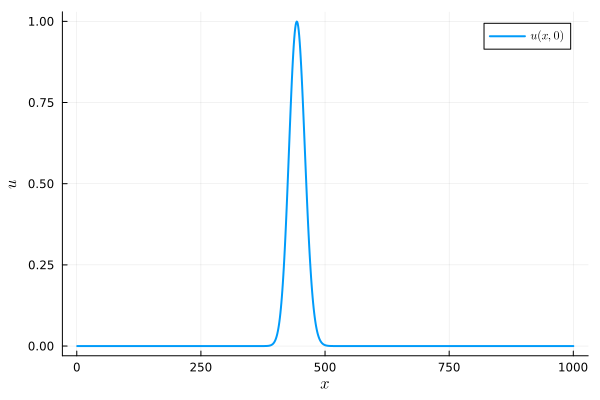

In [6]:
plot(us[:,end],linewidth = 2,label = L"u(x,0)")
xlabel!(L"x")
ylabel!(L"u")

# Data split

In [7]:
train_data = us[:,1:m*100]
val_data = us[:,m*100:2*m*100]

#train_data = us[:,:]
#val_data = us[:,:]

1000×101 Matrix{Float64}:
  4.61315e-18  -3.98889e-17  -1.11908e-16  …   4.84237e-17  -3.52791e-17
  1.9254e-17    8.69407e-17   1.54553e-16      3.47986e-18   9.86216e-17
 -6.13707e-17  -1.35751e-16  -1.74873e-16     -6.80187e-17  -1.444e-16
  1.12228e-16   1.69841e-16   1.61622e-16      1.23893e-16   1.61429e-16
 -1.56521e-16  -1.75136e-16  -1.12349e-16     -1.55451e-16  -1.49578e-16
  1.78784e-16   1.44002e-16   3.49695e-17  …   1.573e-16     1.17936e-16
 -1.67137e-16  -7.82026e-17   5.17375e-17     -1.34444e-16  -8.00241e-17
  1.1716e-16   -8.13401e-18  -1.22319e-16      9.86644e-17   4.85028e-17
 -3.72072e-17   9.05352e-17   1.55034e-16     -6.3294e-17   -3.14614e-17
 -5.11463e-17  -1.43996e-16  -1.415e-16        3.87195e-17   3.11725e-17
  1.21702e-16   1.53638e-16   8.87686e-17  …  -3.00364e-17  -4.49256e-17
 -1.54468e-16  -1.18843e-16  -1.58085e-17      3.69794e-17   6.6868e-17
  1.4122e-16    5.25633e-17  -5.16674e-17     -5.52996e-17  -8.98621e-17
  ⋮                         

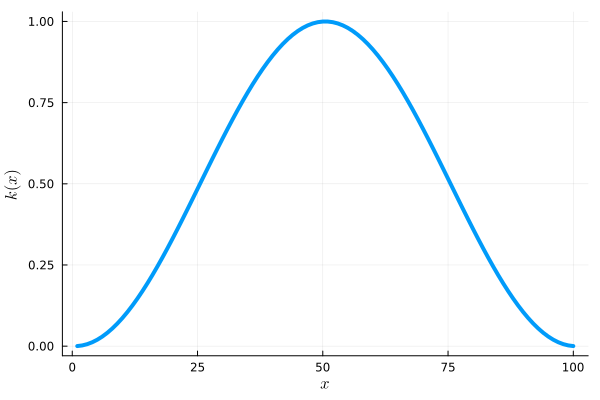

In [8]:
plot(hat_funct(100),linewidth = 4,label = false)
ylabel!(L"$k(x)$")
xlabel!(L"$x$")

# Sum of $k(x)$ functions

In [9]:
N = 300
I = 5
J = Int(N/I)

overlap = 1
r = 1



local_basis = hat_funct((overlap+1)*J,overlap = overlap)
offset = 0
basis = zeros(N,(I)*r)
total_modes = size(basis)[2]
width = size(local_basis)[1]
print(size(local_basis))
for i in 1:I
    basis[1:width,1:r] = local_basis
    basis = circshift(basis,(J,r))
end

(120,)

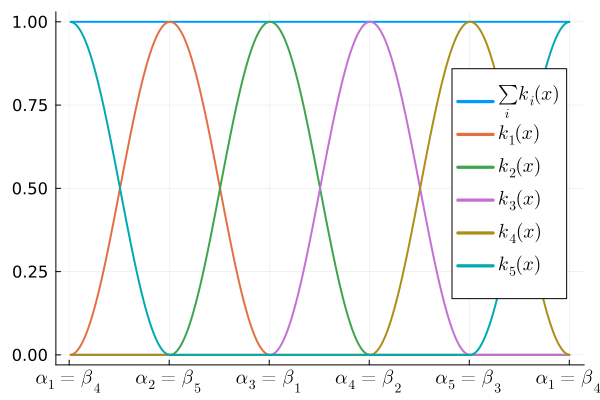

In [10]:
plot(sum(basis,dims = 2),linewidth = 2,label = L"\sum_i k_i(x)",xtickfont=font(13), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13),legend= :right)


plot!(basis,linewidth = 2,label = [L"k_1(x)" L"k_2(x)" L"k_3(x)" L"k_4(x)" L"k_5(x)"],xticks=([0,60,120,180,240,300],[L"\alpha_1=\beta_4",L"\alpha_2=\beta_5",L"\alpha_3 = \beta_1",L"\alpha_4 = \beta_2",L"\alpha_5 = \beta_3",L"\alpha_1 = \beta_4"]),right_margin = 2Plots.mm)
savefig("plots/k.pdf")
plot!()

In [11]:
basis

300×5 Matrix{Float64}:
 0.000171338  0.0  0.0  0.0          0.999829
 0.00154133   0.0  0.0  0.0          0.998459
 0.00427757   0.0  0.0  0.0          0.995722
 0.00837255   0.0  0.0  0.0          0.991627
 0.013815     0.0  0.0  0.0          0.986185
 0.0205901    0.0  0.0  0.0          0.97941
 0.0286793    0.0  0.0  0.0          0.971321
 0.0380602    0.0  0.0  0.0          0.96194
 0.0487074    0.0  0.0  0.0          0.951293
 0.0605914    0.0  0.0  0.0          0.939409
 0.0736799    0.0  0.0  0.0          0.92632
 0.0879369    0.0  0.0  0.0          0.912063
 0.103323     0.0  0.0  0.0          0.896677
 ⋮                                   
 0.0          0.0  0.0  0.0879369    0.912063
 0.0          0.0  0.0  0.0736799    0.92632
 0.0          0.0  0.0  0.0605914    0.939409
 0.0          0.0  0.0  0.0487074    0.951293
 0.0          0.0  0.0  0.0380602    0.96194
 0.0          0.0  0.0  0.0286793    0.971321
 0.0          0.0  0.0  0.0205901    0.97941
 0.0          0.0  0.0  0

# Find best parameters for local POD

In [67]:
overlap = 1

#global_train_errs = []
local_train_errs = []
overlap_train_errs = []

#global_val_errs = []
local_val_errs = []
overlap_val_errs = []

Is = m*[5,10,20,25,50]

for I in Is
    rs = collect(1:floor(Int,100/I))
    #global_train_err = []
    local_train_err = []
    overlap_train_err = []

    #global_val_err = []
    local_val_err = []
    overlap_val_err = []
    for r in rs
        #global_POD = gen_ROM(train_data,f,r = r,I = I,localize = false  )
        
        local_POD = gen_ROM(train_data,f,r = r,I = I,localize = true,overlap = 0 )
        overlap_POD = gen_ROM(train_data,f,r = r,I = I,localize = true,overlap = overlap)

        #push!(global_train_err,mean((train_data - global_POD.P *train_data).^2 ))
        push!(local_train_err,compute_error(train_data - local_POD.P *train_data ))
        push!(overlap_train_err,compute_error((train_data - overlap_POD.P *train_data )))

        #push!(global_val_err,mean((val_data - global_POD.P *val_data).^2 ))
        push!(local_val_err,compute_error((val_data - local_POD.P *val_data )))
        push!(overlap_val_err,compute_error((val_data - overlap_POD.P *val_data )))
    end
    
    #push!(global_train_errs,global_train_err)
    push!(local_train_errs,local_train_err)
    push!(overlap_train_errs,overlap_train_err)

    #push!(global_val_errs,global_val_err)
    push!(local_val_errs,local_val_err)
    push!(overlap_val_errs,overlap_val_err)
    
    
end

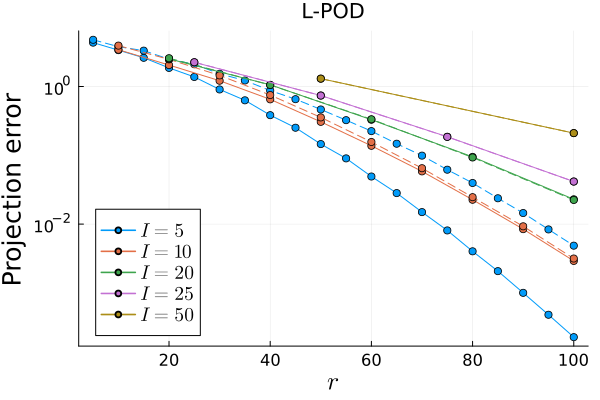

In [68]:
plot(yscale = :log, legend=:bottomleft,xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13))
for i in 1:size(Is)[1]
    I = Is[i]
    plot!(collect(1:size(local_train_errs[i])[1])*Is[i],local_train_errs[i],marker = true,label = L"I = %$I",color = i) 
    plot!(collect(1:size(local_val_errs[i])[1])*Is[i],local_val_errs[i],marker = true,label = false, linestyle = :dash,color = i) 
    
end
xlabel!(L"r")
ylabel!("Projection error")
title!("L-POD")
savefig("plots/proj_local.pdf")

plot!()

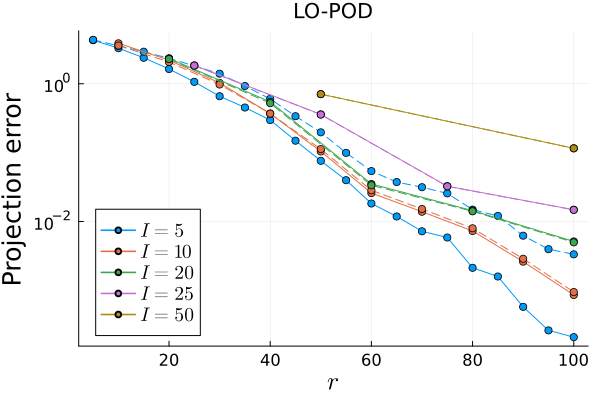

In [69]:
plot(yscale = :log, 
    legend=:bottomleft,xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13))
for i in 1:size(Is)[1]
    I = Is[i]
    plot!(collect(1:size(overlap_train_errs[i])[1])*Is[i],overlap_train_errs[i],marker = true,label = L"I = %$I",color = i) 
    plot!(collect(1:size(overlap_val_errs[i])[1])*Is[i],overlap_val_errs[i],marker = true,label = false, linestyle = :dash,color = i) 
    
end
xlabel!(L"r")
ylabel!("Projection error")
title!("LO-POD")
savefig("plots/proj_overlap.pdf")
plot!()

# Compare ROMs

In [70]:
I = m*10
overlap = 1


local_train_err = []
overlap_train_err = []
rs = collect(1:10)


local_val_err = []
overlap_val_err = []



for r in rs
    
    
    local_POD = gen_ROM(train_data,f,r = r,I = I,localize = true,overlap = 0 )
    overlap_POD = gen_ROM(train_data,f,r = r,I = I,localize = true,overlap = overlap)
    
    
    
    
    push!(local_train_err,compute_error((train_data - local_POD.P *train_data )))
    push!(overlap_train_err,compute_error((train_data - overlap_POD.P *train_data )))
    
    
    push!(local_val_err,compute_error((val_data - local_POD.P *val_data )))
    push!(overlap_val_err,compute_error((val_data - overlap_POD.P *val_data )))
    

    
    
end

In [71]:
global_val_err = []
global_train_err = []

global_nonzero = []

glob_rs = collect(1:100)

for r in glob_rs 
    global_POD = gen_ROM(train_data,f,r = r,I = 1,localize = false  )
    push!(global_train_err,compute_error((train_data - global_POD.P *train_data) ))
    push!(global_val_err,compute_error((val_data - global_POD.P *val_data) ))
end

┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584


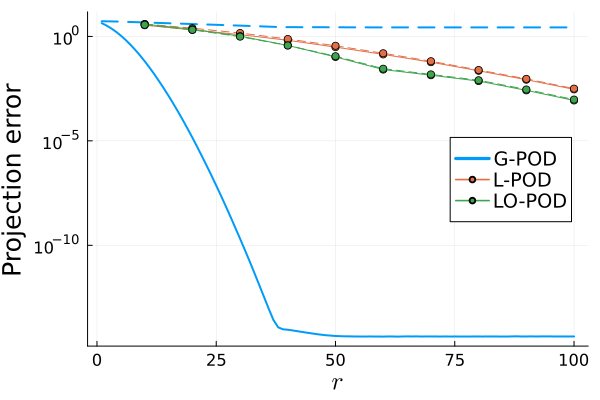

In [72]:
plot(glob_rs, global_train_err,linewidth = 2,label = "G-POD",yscale = :log, 
    xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13),color = 1,legend=:right)
plot!(glob_rs, global_val_err,linewidth = 2,linestyle = :dash,color = 1,label = false)
plot!(rs * I, local_train_err,marker = true,label = "L-POD",color = 2)
plot!(rs * I, local_val_err,marker = true,linestyle = :dash,color = 2,label = false)
plot!(rs * I, overlap_train_err,marker = true,label = "LO-POD",color = 3)
plot!(rs * I, overlap_val_err,marker = true,linestyle = :dash,color = 3,label = false)
xlabel!(L"r")
ylabel!("Projection error")
savefig("plots/projection.pdf")
plot!()

# Plot basis

In [73]:
I = 10
r = 6
overlap =1

global_POD = gen_ROM(train_data,f,r = r,I = I,localize = false  )
local_POD = gen_ROM(train_data,f,r = r,I = I,localize = true,overlap = 0 )
overlap_POD = gen_ROM(train_data,f,r = r,I = I,localize = true,overlap = overlap)



ROM_struct(sparse([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  991, 992, 993, 994, 995, 996, 997, 998, 999, 1000], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

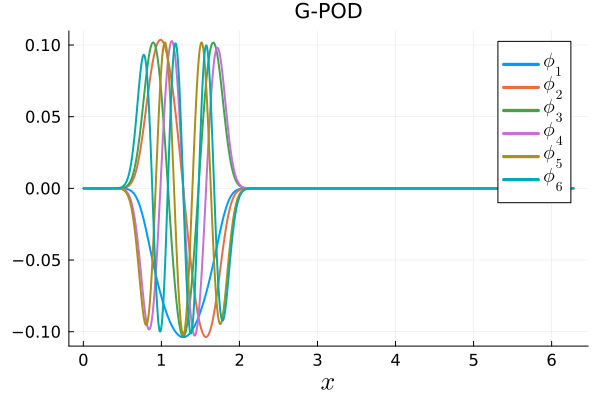

In [19]:
plot(xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13))
for i in 1:r
    plot!(x,global_POD.basis[:,i],linewidth = 2,label = L"\phi_{%$i}")
end
xlabel!(L"x")
title!("G-POD")
savefig("plots/basis_global.pdf")
plot!()



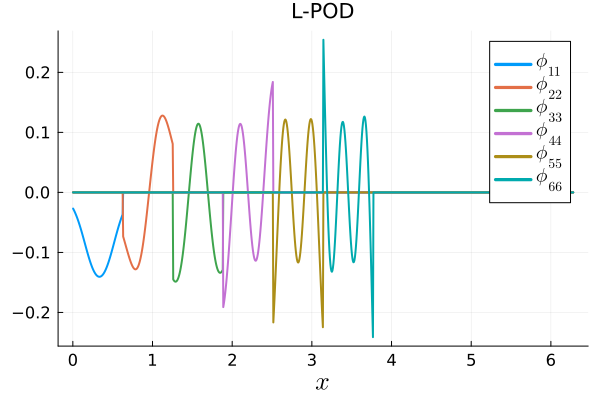

In [20]:
plot(xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13))
for i in 1:r
    plot!(x,local_POD.basis[:,1+(i-1)*(r+1)],linewidth = 2,label = L"\phi_{%$i%$i}")
end
xlabel!(L"x")
title!("L-POD")
savefig("plots/basis_local.pdf")
plot!()



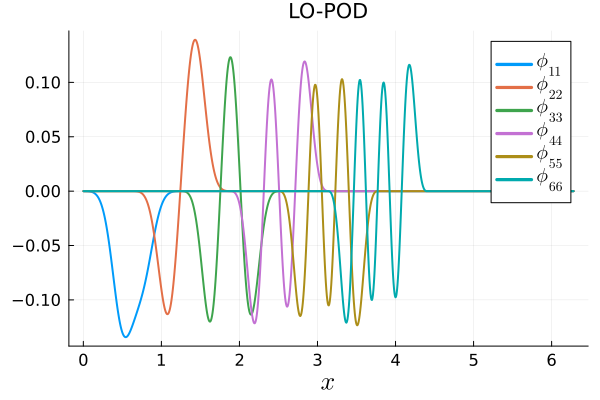

In [21]:
plot(xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13))
for i in 1:r
    plot!(x,overlap_POD.basis[:,1+(i-1)*(r+1)],linewidth = 2,label = L"\phi_{%$i%$i}")
end
xlabel!(L"x")
title!("LO-POD")
savefig("plots/basis_overlap.pdf")
plot!()

In [22]:
I = 10
r = 6
overlap =1

global_POD = gen_ROM(train_data,f,r = r,I = I,localize = false  )
local_POD = gen_ROM(train_data,f,r = r,I = I,localize = true,overlap = 0 )
overlap_POD = gen_ROM(train_data,f,r = r,I = I,localize = true,overlap = overlap)



ROM_struct(sparse([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  991, 992, 993, 994, 995, 996, 997, 998, 999, 1000], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

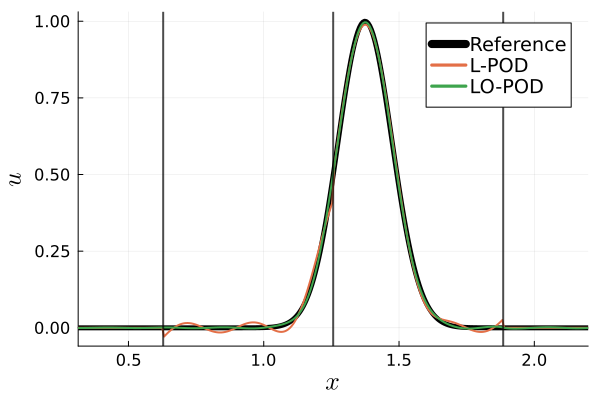

In [23]:
index = 60
plot(xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13))
plot!(x,train_data[:,index] ,linewidth = 5,color = "black", label = "Reference")
plot!(x,local_POD.P*train_data[:,index] ,linewidth = 2,color = 2,label = "L-POD")
plot!(x,overlap_POD.P*train_data[:,index] ,linewidth = 2,color = 3, label = "LO-POD")
xlabel!(L"x")
ylabel!(L"u")
xlims!(0.05*2*pi,0.35*2*pi)
vline!([0.1*2*pi], color = "black",linewidth = 2,alpha = 0.7,label = false)
vline!([0.2*2*pi], color = "black",linewidth = 2,alpha = 0.7,label = false)
vline!([0.3*2*pi], color = "black",linewidth = 2,alpha = 0.7,label = false)
#plot!(x,train_data[:,index],linewidth = 2)
savefig("plots/discontinuity.pdf")
plot!()

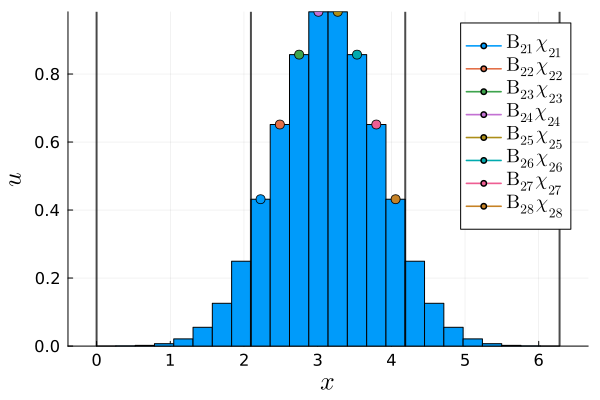

In [24]:
n = 24
y = (collect(1:n).-1/2)/n .* omega
u = exp.(-(y .- pi) .^ 2)


plot(bar(y,u,label = false, bar_width = omega/n),xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13))
vline!([1/3*2*pi], color = "black",linewidth = 2,alpha = 0.7,label = false)
vline!([2/3*2*pi], color = "black",linewidth = 2,alpha = 0.7,label = false)
vline!([0], color = "black",linewidth = 2,alpha = 0.7,label = false)
vline!([2*pi], color = "black",linewidth = 2,alpha = 0.7,label = false)
xlabel!(L"x")
ylabel!(L"u")
#plot!(bar(y,u))
for i in 9:16
    index = i-8
    plot!([y[i],],[u[i],],marker = true,markersize = 5,color = i-8,label = L"\mathrm{B}_{2%$index}\chi_{2%$index}")
end

savefig("plots/local_basis.pdf")
plot!()


# Single solution \& energy conservation

# Simulation

In [25]:
#############################
dt = 0.01 # time-step size
T = 5  #simulate until t=T
save_every = 1 # save reference data every 10 time-steps
#samples = 1 # number of simulations



results = []
energy_error = []

ROMs = [global_POD,local_POD,overlap_POD]

u0 = exp.(-50 .* (1/4*pi .- x) .^2)
#u0 = (1 .< x) .* (x .< 2)
for i in ROMs
    
    
    a0 = i.S_inv * i.basis'*u0
    @time begin
    a,da,t = simulation(a0,zeros(size(i.S)[1]),dt,T,  i.f  ,F = 0,save_every = save_every) # simulate
    end

    # Save quantities
    u_r = i.basis * a
    push!(energy_error,((x[2]-x[1])* sum(u_r .* (i.basis * i.f(a,x,0)),dims = 1)))
    push!(results,u_r)
    
end

@time begin
ref_u,du,t = simulation(u0,x,0.01,T,  f  ,F = 0,save_every = Int(dt/0.01)*save_every) # simulate
push!(results,ref_u)
push!(energy_error, ((x[2]-x[1])* sum(ref_u .* f(ref_u,x,0),dims = 1)))
end
0

  0.259741 seconds (267.07 k allocations: 22.037 MiB, 8.67% gc time, 87.53% compilation time)
  0.193592 seconds (269.38 k allocations: 22.294 MiB, 95.11% compilation time)
  0.009292 seconds (43.60 k allocations: 8.582 MiB)
  0.226842 seconds (120.81 k allocations: 291.187 MiB, 21.56% gc time, 31.58% compilation time)


0

# Simulation with large timestep

In [26]:
#############################
dt = 0.05 # time-step size
T = 5  #simulate until t=T
save_every = 1 # save reference data every 10 time-steps
#samples = 1 # number of simulations


larger_results = []


u0 = exp.(-50 .* (1/4*pi .- x) .^2)
#u0 = (1 .< x) .* (x .< 2)
for i in ROMs
    
    
    a0 = i.S_inv * i.basis'*u0
    @time begin
    a,da,t_larger = simulation(a0,zeros(size(i.S)[1]),dt,T,  i.f  ,F = 0,save_every = save_every) # simulate
    end

    # Save quantities
    u_r = i.basis * a
    push!(larger_results,u_r)
    
end

@time begin
ref_u,du,t_larger = simulation(u0,x,0.01,T,  f  ,F = 0,save_every = Int(dt/0.01)*save_every) # simulate
push!(larger_results,ref_u)

end
0

  0.001926 seconds (8.30 k allocations: 1.677 MiB)
  0.002216 seconds (8.80 k allocations: 1.731 MiB)
  0.001939 seconds (8.80 k allocations: 1.731 MiB)
  0.094342 seconds (55.14 k allocations: 221.763 MiB, 20.82% gc time)


0

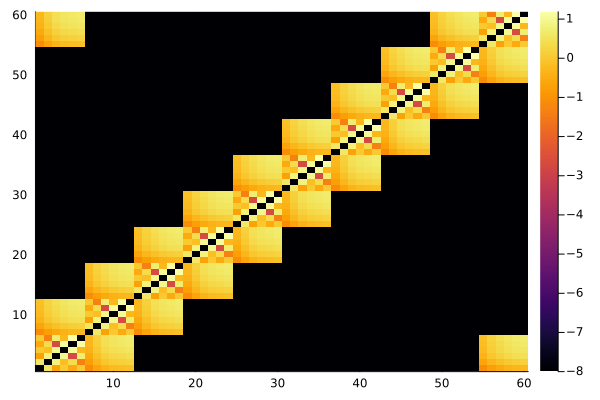

In [27]:
heatmap(log10.(abs.(local_POD.A .+0.00000001)))

In [28]:
local_counter = 0
overlap_counter = 0
counter = 0
for i in 1:size(local_POD.A)[1]
    for j in 1:size(local_POD.A)[2]
        if local_POD.A[i,j] != 0
            local_counter += 1
        end
        if overlap_POD.A[i,j] != 0
            overlap_counter += 1
        end
        
        counter += 1
    end
end

In [29]:
overlap_counter

1800

In [30]:
local_counter

1070

In [31]:
counter

3600

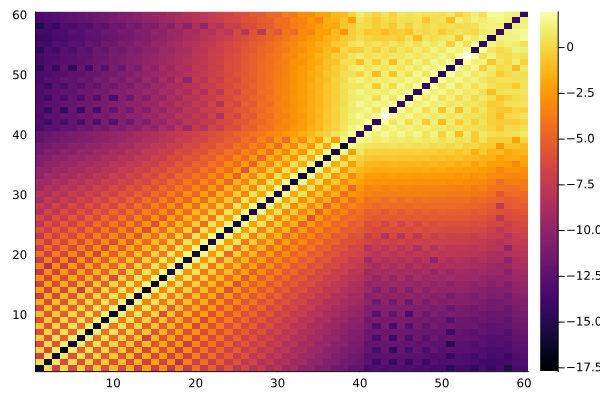

In [32]:
heatmap(log10.(abs.(global_POD.A)))

# Heatmaps

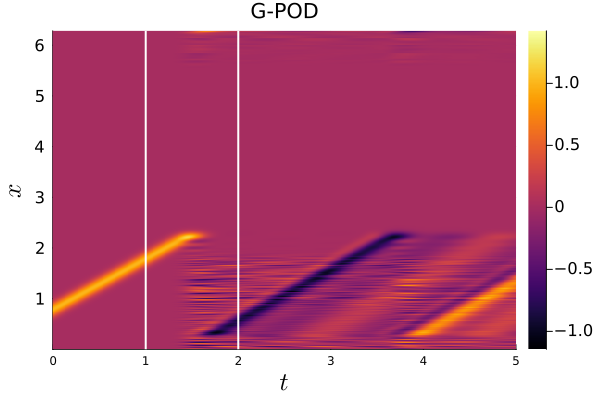

In [33]:
heatmap(t'[1:end],x,results[1], 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13),right_margin = 4Plots.mm)



vline!([1],color = :white, linewidth = 2,label = false)
vline!([2],color = :white, linewidth = 2,label = false)
xlabel!(L"t")
ylabel!(L"x")
title!("G-POD")
savefig("plots/G_POD.pdf")
plot!()

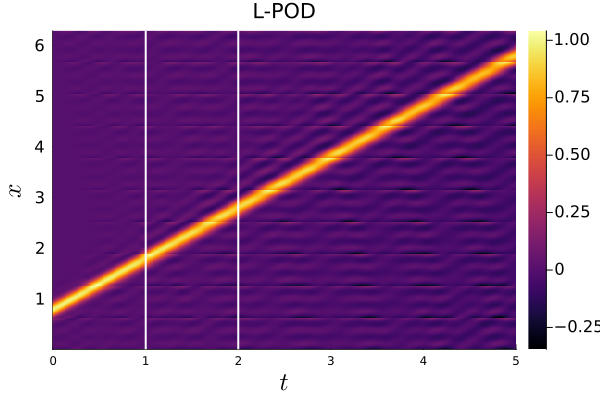

In [34]:
heatmap(t'[1:end],x,results[2],ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13),right_margin = 4Plots.mm)

vline!([1],color = :white, linewidth = 2,label = false)
vline!([2],color = :white, linewidth = 2,label = false)
xlabel!(L"t")
ylabel!(L"x")
title!("L-POD")
savefig("plots/L_POD.pdf")
plot!()

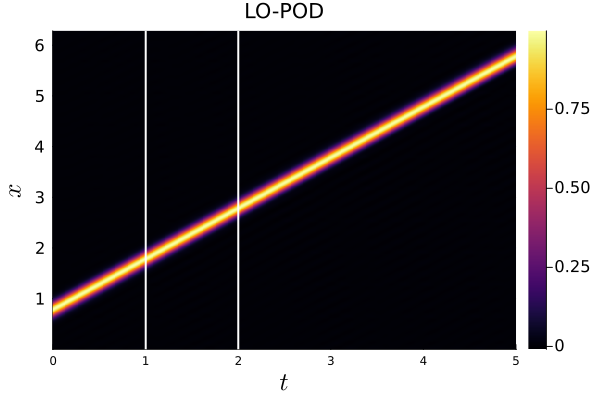

In [35]:
heatmap(t'[1:end],x,results[3],ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13),right_margin = 4Plots.mm)

vline!([1],color = :white, linewidth = 2,label = false)
vline!([2],color = :white, linewidth = 2,label = false)
xlabel!(L"t")
ylabel!(L"x")
title!("LO-POD")
savefig("plots/LO_POD.pdf")
plot!()

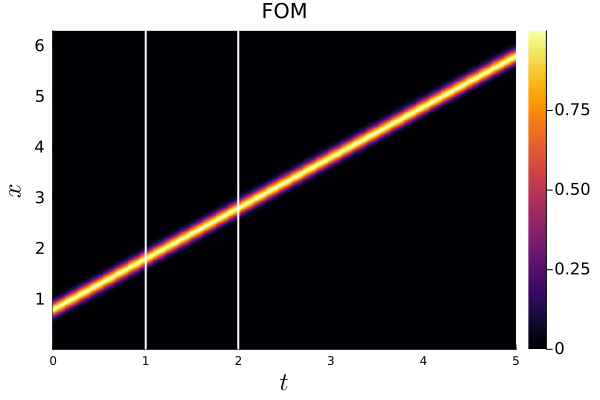

In [36]:
heatmap(t'[1:end],x,results[4], ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13),right_margin = 4Plots.mm)

vline!([1],color = :white, linewidth = 2,label = false)
vline!([2],color = :white, linewidth = 2,label = false)
xlabel!(L"t")
ylabel!(L"x")
title!("FOM")

savefig("plots/reference.pdf")
plot!()

┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584


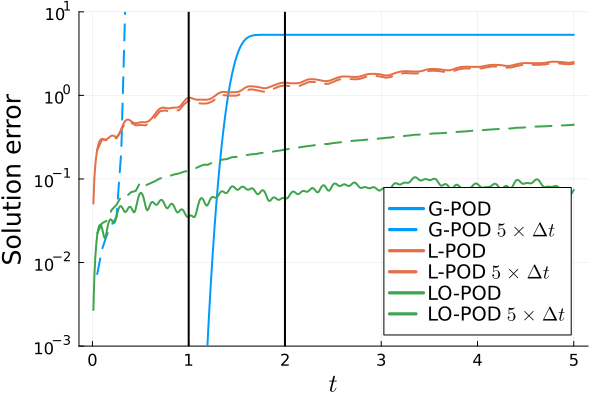

In [37]:
plot(ylimits = (1e-3,10.),xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13),legend = :bottomright)
labels = ["G-POD","L-POD","LO-POD"]
for i in 1:size(ROMs)[1]
    plot!(t'[2:end],compute_error((ROMs[i].P * results[4] - results[i]),average = false)'[2:end],yscale = :log,label = labels[i],linewidth = 2,color = i)
    plot!(t_larger'[2:end],compute_error((ROMs[i].P * larger_results[4] - larger_results[i]),average = false)'[2:end],yscale = :log,label = labels[i] * " " * L"5\times\Delta t",linewidth = 2,color = i,linestyle = :dash)
end
vline!([1],linewidth = 2,color = :black,label =false)
vline!([2],linewidth = 2,color = :black,label =false)
plot!()
xlabel!(L"t")

ylabel!("Solution error")
savefig("plots/error_trajectory.pdf")
plot!()

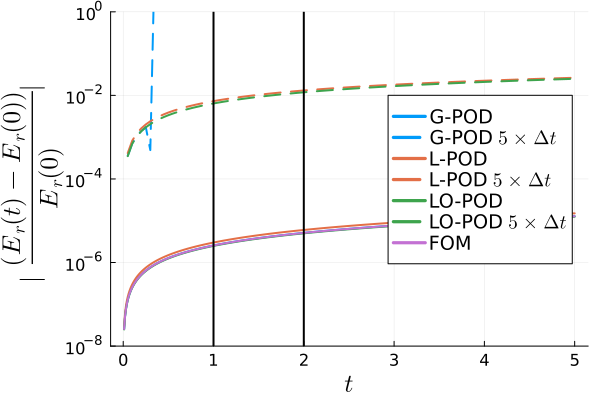

In [38]:
plot(yscale = :log,ylimits = (1e-8,1.),xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13),left_margin = 3Plots.mm,legend = :right)

labels = ["G-POD","L-POD","LO-POD","FOM"]
for i in 1:size(ROMs)[1]+1
    plot!(t'[2:end],abs.((sum((results[i]).^2,dims = 1)'[2:end] .- sum((results[i]).^2,dims = 1)'[1])/(sum((results[i]).^2,dims = 1)'[1])),label = labels[i],linewidth = 2,color = i)
    if i != 4
        plot!(t_larger'[2:end],abs.((sum((larger_results[i]).^2,dims = 1)'[2:end] .- sum((larger_results[i]).^2,dims = 1)'[1])/(sum((larger_results[i]).^2,dims = 1)'[1])),label = labels[i]* " " * L"5 \times \Delta t",linewidth = 2,linestyle = :dash,color = i)
    end
end
vline!([1],linewidth = 2,color = :black,label = false)
vline!([2],linewidth = 2,color = :black,label =false)
xlabel!(L"t")
ylabel!(L"|\frac{(E_r(t)-E_r(0))}{E_r(0)}|")
savefig("plots/energy_trajectory.pdf")
plot!()

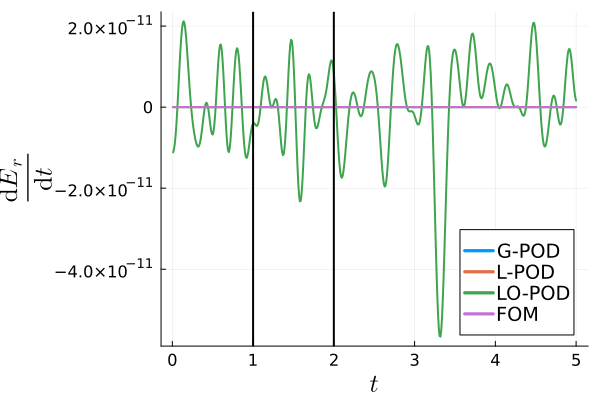

In [39]:
plot(xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13),left_margin = 2Plots.mm)
labels = ["G-POD","L-POD","LO-POD","FOM"]
for i in 1:size(ROMs)[1]+1
    plot!(t'[2:end],energy_error[i][2:end],label = labels[i],linewidth = 2)
end
vline!([1],linewidth = 2,color = :black,label = false)
vline!([2],linewidth = 2,color = :black,label =false)
plot!()
xlabel!(L"t")
ylabel!(L"\frac{\mathrm{d}E_r}{\mathrm{d}t}")
savefig("plots/change_in_energy_trajectory.pdf")
plot!()

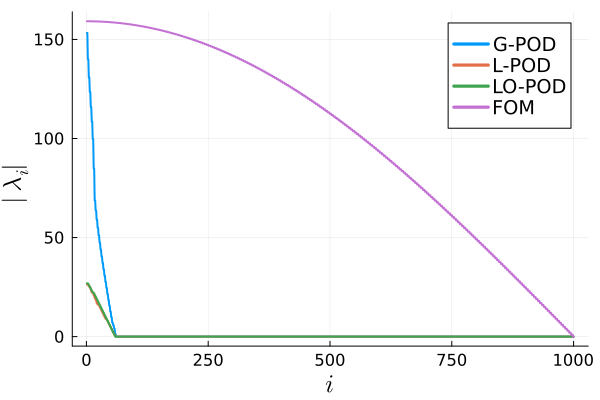

In [40]:
plot(xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13))

plot!(reverse(sort(real.(abs.(eigvals(global_POD.p_A))))),label = "G-POD",linewidth = 2)
plot!(reverse(sort(real.(abs.(eigvals(local_POD.p_A))))),label = "L-POD",linewidth = 2)
plot!(reverse(sort(real.(abs.(eigvals(overlap_POD.p_A))))),label = "LO-POD",linewidth = 2)
plot!(reverse(sort(real.(abs.(eigvals(Matrix(D1)))))),label = "FOM",linewidth = 2)
xlabel!(L"i")
ylabel!(L"|\lambda_i|")
savefig("plots/eigenvalues.pdf")
plot!()

# Plot convergence

## Run finite difference  

In [53]:
_Ns_ = m*10*collect(1:99)

fd_error = []
fd_eval_times = []

T = 5
dt = 0.01 # time-step size

u0 = exp.(-50 .* (1/4*pi .- x) .^2)
ref_u,du,t = simulation(u0,x,0.01,T,  f  ,F = 0,save_every = Int(dt/0.01)*save_every)

samples = 10

for _N_ in tqdm(_Ns_)

    #r = 300



    #overlap =true


    _x_ = (collect(1:_N_).-1/2)/_N_ .* omega

    _D1_ = gen_stencil(size(_x_)[1],[-1,0,1]./(2*(_x_[2]-_x_[1])),[-1,0,1])
    _D2_ = gen_stencil(size(_x_)[1],[1,-2,1]./(_x_[2]-_x_[1])^2,[-1,0,1])
    _D3_ = gen_stencil(size(_x_)[1],[-1,2,-2,1]./(2*(_x_[2]-_x_[1]))^3,[-2,-1,1,2])
    #_f_(u,x,t,v = 0.01) = -4.5/3 * (u .* _D1_*u + _D1_*u.^2) + _D3_*u
    #_f_(u,x,t,v = 0.01) = -1/3 * (u .* _D1_*u + _D1_*u.^2) + v*_D2_*u
    _f_(u,x,t,v = 0.0,D1 = _D1_,D2 = _D2_) = -D1*u #+ v*D2*u
    

    M = interpolation_matrix(x,_x_)

    #############################
    
    u0 = exp.(-50 .* (1/4*pi .- _x_) .^2)
    u = 0 
    du = 0
    t = 0
    eval_times = []
    for i in 1:samples
        eval_time = @timed begin
        u,du,t = simulation(u0,_x_,dt,T,  _f_  ,F = 0,save_every = save_every) # simulate
        end
        if i > 1
            push!(eval_times,eval_time[2])
        end
    end
    push!(fd_error,compute_error((ref_u -M* u)))
    push!(fd_eval_times,mean(eval_times))

end


0.0%┣                                               ┫ 0/99 [00:00<00:00, -0s/it]
1.0%┣▍                                          ┫ 1/99 [00:00<Inf:Inf, InfGs/it]
2.0%┣█                                               ┫ 2/99 [00:00<00:28, 3it/s]
4.0%┣██                                              ┫ 4/99 [00:00<00:13, 7it/s]
5.1%┣██▍                                             ┫ 5/99 [00:00<00:12, 8it/s]
6.1%┣███                                             ┫ 6/99 [00:01<00:11, 9it/s]
7.1%┣███▍                                            ┫ 7/99 [00:01<00:10, 9it/s]
8.1%┣███▉                                            ┫ 8/99 [00:01<00:10, 9it/s]
9.1%┣████▍                                           ┫ 9/99 [00:01<00:10, 9it/s]
10.1%┣████▋                                         ┫ 10/99 [00:01<00:10, 9it/s]
11.1%┣█████▏                                        ┫ 11/99 [00:01<00:10, 8it/s]
12.1%┣█████▋                                        ┫ 12/99 [00:01<00:11, 8it/s]
13.1%┣██████                

## run POD

In [54]:
rs = collect(1:10)
I = m*10
overlap =1

global_error = []
global_eval_times = []
global_sparsity = []

local_error = []
local_eval_times = []
local_sparsity = []


overlap_error = []
overlap_eval_times = []
overlap_sparsity = []


u0 = exp.(-50 .* (1/4*pi .- x) .^2)
ref_u,du,t = simulation(u0,x,0.01,T,  f  ,F = 0,save_every = Int(dt/0.01)*save_every)

samples = 10

for r in tqdm(rs)
    
    global_POD = gen_ROM(train_data,f,r = r,I = I,localize = false,overlap = 0 )
    local_POD = gen_ROM(train_data,f,r = r,I = I,localize = true,overlap = 0 )
    overlap_POD = gen_ROM(train_data,f,r = r,I = I,localize = true,overlap = overlap)


    #############################
    dt = 0.01 # time-step size
    T = 5  #simulate until t=T
    save_every = 1 # save reference data every 10 time-steps
    #samples = 1 # number of simulations


    t = 0
    results = []
    energy_error = []

    ROMs = [global_POD,local_POD,overlap_POD]
    error = [global_error,local_error,overlap_error]
    eval_times = [global_eval_times,local_eval_times,overlap_eval_times]
    sparsity = [global_sparsity,local_sparsity,overlap_sparsity]

    u0 = exp.(-50 .* (1/4*pi .- x) .^2)
    for (i,j,k,l) in zip(ROMs,error,eval_times,sparsity)


        a0 = i.S_inv * i.basis'*u0
        ## First run for compilation
        a =0
        da = 0
        t = 0
        eval_times = []
        for l in 1:samples
            eval_time = @timed begin
            a,da,t = simulation(a0,zeros(size(i.S)[1]),dt,T,  i.f  ,F = 0,save_every = save_every) # simulate
            end
            if l > 1
                push!(eval_times,eval_time[2])
            end
        end

        # Save quantities
        u_r = i.basis * a
        push!(j,compute_error(i.P*ref_u - u_r))
        push!(k,mean(eval_times))
        push!(l,count(! iszero, i.A))

    end

end

0.0%┣                                               ┫ 0/10 [00:00<00:00, -0s/it]
10.0%┣████▏                                     ┫ 1/10 [00:00<Inf:Inf, InfGs/it]
20.0%┣█████████▍                                     ┫ 2/10 [00:01<00:05, 2it/s]
30.0%┣██████████████                                 ┫ 3/10 [00:01<00:03, 2it/s]
40.0%┣██████████████████▉                            ┫ 4/10 [00:01<00:03, 2it/s]
50.0%┣███████████████████████▌                       ┫ 5/10 [00:02<00:02, 2it/s]
60.0%┣████████████████████████████▏                  ┫ 6/10 [00:02<00:02, 2it/s]
70.0%┣█████████████████████████████████              ┫ 7/10 [00:03<00:01, 2it/s]
80.0%┣█████████████████████████████████████▋         ┫ 8/10 [00:03<00:01, 2it/s]
90.0%┣██████████████████████████████████████████▎    ┫ 9/10 [00:04<00:00, 2it/s]
100.0%┣█████████████████████████████████████████████┫ 10/10 [00:04<00:00, 2it/s]
100.0%┣█████████████████████████████████████████████┫ 10/10 [00:04<00:00, 2it/s]


┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584


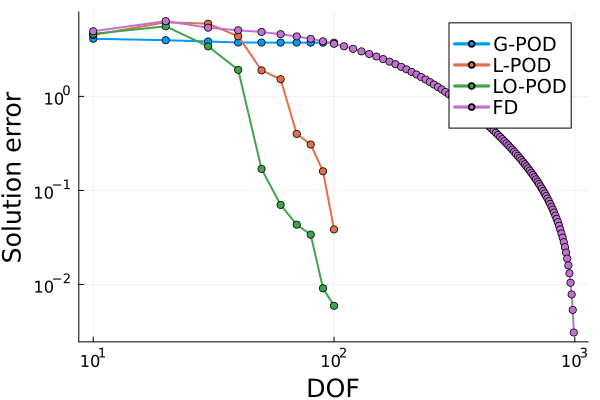

In [60]:
plot(10*collect(1:size(global_error)[1]),global_error,linewidth = 2,xscale = :log,marker = true,yscale = :log,label= "G-POD",xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13))
plot!(10*collect(1:size(local_error)[1]),local_error,linewidth = 2,marker = true,label = "L-POD")
plot!(10*collect(1:size(overlap_error)[1]),overlap_error,linewidth = 2,marker = true,label = "LO-POD")
plot!(10*collect(1:size(fd_error)[1]),fd_error,linewidth = 2,marker = true, label = "FD")
xlabel!("DOF")
ylabel!("Solution error")
savefig("plots/DOF_vs_error.pdf")
plot!()

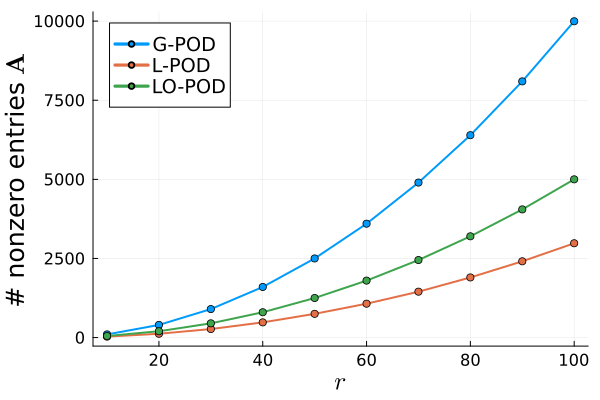

In [66]:
plot(10*collect(1:size(global_error)[1]),global_sparsity,linewidth = 2,marker = true,label= "G-POD",xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13))
plot!(10*collect(1:size(local_error)[1]),local_sparsity,linewidth = 2,marker = true,label = "L-POD")
plot!(10*collect(1:size(overlap_error)[1]),overlap_sparsity,linewidth = 2,marker = true,label = "LO-POD")
xlabel!(L"r")
ylabel!("# nonzero entries " * L"\mathbf{A}")
savefig("plots/sparsity.pdf")
plot!()

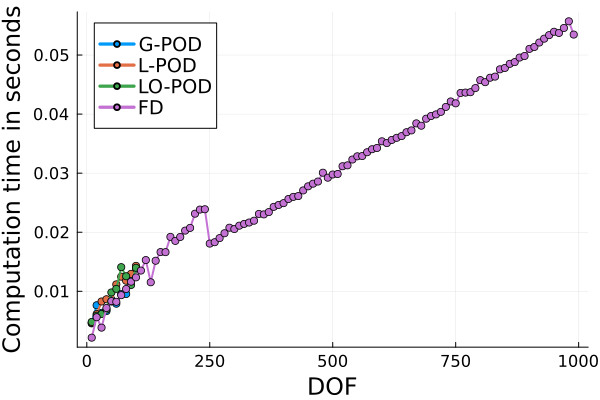

In [62]:
plot(10*collect(1:size(global_eval_times)[1]),global_eval_times,linewidth = 2,marker = true,label= "G-POD",xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(16), 
    legendfont=font(13))
plot!(10*collect(1:size(local_eval_times)[1]),local_eval_times,linewidth = 2,marker = true,label = "L-POD")
plot!(10*collect(1:size(overlap_eval_times)[1]),overlap_eval_times,linewidth = 2,marker = true,label = "LO-POD")
plot!(10*collect(1:size(fd_eval_times)[1]),fd_eval_times,linewidth = 2,marker = true, label = "FD")

xlabel!("DOF")
ylabel!("Computation time in seconds")
savefig("plots/DOF_vs_computation_time.pdf")
plot!()

In [63]:
error_range = log10.(extrema(fd_error))
points = 50
eval_errs = 10 .^ (LinRange(error_range...,points))

errs = [global_error,local_error,overlap_error,fd_error]
eval_times = [global_eval_times,local_eval_times,overlap_eval_times,fd_eval_times]
err_times = [NaN * zeros(points) for i in errs]

for i in 1:size(errs)[1]
    lower = false
    for j in 1:size(eval_errs)[1]
        for k in 1:size(errs[i])[1]
            if isnan(err_times[i][j])
                if errs[i][k] <= eval_errs[j]
                    err_times[i][j] = eval_times[i][k]
                end
            else
                if eval_times[i][k] < err_times[i][j]
                    err_times[i][j] = eval_times[i][k]
                end
            end

        end
    end
    
end

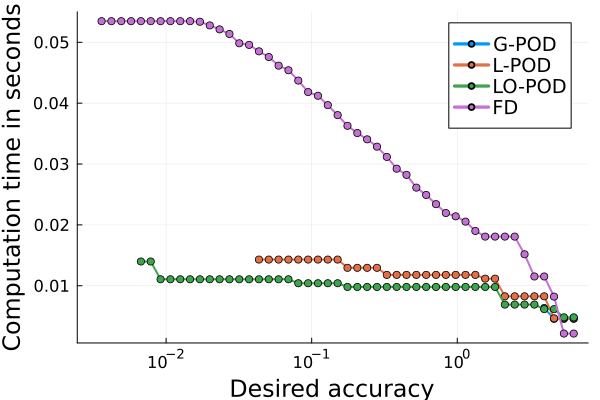

In [64]:
labels = ["G-POD","L-POD","LO-POD","FD"]
plot(xscale = :log,xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(16), 
    legendfont=font(13))
for i in 1:size(labels)[1]
    plot!(eval_errs,err_times[i],label = labels[i],marker = true,linewidth = 2)
end

plot!()
xlabel!("Desired accuracy")
ylabel!("Computation time in seconds")
savefig("plots/accuracy_vs_computation_time.pdf")
plot!()